In [38]:
# 3rd party
import sympy as sp
import numpy as np
from IPython.utils.io import capture_output
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# Our stuff
import mainframe as mf
import nuclei_func as nf
from mainframe import Region

In [39]:
################################################################################
# INPUT DATA
################################################################################
micro_abs_water = nf.mixture([0.33, 4.2],[2, 1],'normalize') 
micro_abs_U235 = 101 
micro_fiss_U235 = 678 

density_water = 1
density_U235 = 19.1

# Defining the temperature correction factor
def T_correction(T_new):
    return np.sqrt(293/(T_new+273))

# Defining the macroscopic cross sections
macro_abs_water = nf.macro(micro_abs_water, density_water, 18) * T_correction(60)
macro_abs_U235 = nf.macro(micro_abs_U235, density_U235, 235) * T_correction(60)
macro_fiss_U235 = nf.macro(micro_fiss_U235, density_U235, 235) * T_correction(60)

# Defining the enrichment as a symbol
qual = sp.symbols('qual', positive=True, real=True)

# Defining the macroscopic cross sections of the mixtures
macro_abs_refl = nf.mixture([macro_abs_water, 0], [1, 0])
macro_fiss = nf.mixture([macro_fiss_U235, 0], [qual, 1-qual])
macro_abs_core = nf.mixture([macro_abs_water, macro_abs_U235], [1-qual, qual])

In [40]:
################################################################################
# Defining the regions
################################################################################
symmetrical_problem = True
Core_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_core, 
    Fiss=macro_fiss, 
    Nu=2.44, 
    Pos1=0, 
    Pos2=25, 
    composition='c', 
    power=25*25
)

Reflector_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_refl, 
    Fiss=0, 
    Nu=0, 
    Pos1=25, 
    Pos2=sp.oo, 
    composition='r', 
    power=0
)
regions = [Core_1, Reflector_1]

In [41]:
################################################################################
# Solve the problem
################################################################################
with capture_output() as captured:
    equations, fluxes, boundaries, interfaces, powers = mf.main(regions, symmetrical_problem)

# Show the system
system = fluxes + boundaries + interfaces + powers
for eq in system:
    display(eq)

Eq(phi_1(x), C_1*sin(Bg_1*x) + C_2*cos(Bg_1*x))

Eq(phi_2(x - 25), C_3*exp(-(x - 25)/L_2) + C_4*exp((x - 25)/L_2))

Eq(Bg_1*C_1, 0)

Eq(C_4, 0)

Eq(C_1*sin(Bg_1*x_1) + C_2*cos(Bg_1*x_1), C_3*exp(-(x_1 - 25)/L_2) + C_4*exp((x_1 - 25)/L_2))

Eq(-D_1*(Bg_1*C_1*cos(Bg_1*x_1) - Bg_1*C_2*sin(Bg_1*x_1)), -D_2*(-C_3*exp(-(x_1 - 25)/L_2)/L_2 + C_4*exp((x_1 - 25)/L_2)/L_2))

Eq(1.05479608235362e-9*qual*(-C_1*cos(25*Bg_1)/Bg_1 + C_1/Bg_1 + C_2*sin(25*Bg_1)/Bg_1), 625)

In [42]:
################################################################################
# Substitute known values
################################################################################
with capture_output() as captured:
    system = mf.compute(system, regions)

# Get rid of any True expressions resulting from =zero conditions
system_cleaned = []
L_2_val = np.sqrt(Reflector_1.Diffusion/Reflector_1.Absorption)
L_2 = sp.symbols('L_2', positive=True)
for eq in system:
    # eq = eq.subs(L_2, L_2_val)
    if eq != True:
        system_cleaned.append(eq)
        display(eq)
system = system_cleaned

Eq(phi_1(x), C_2*cos(Bg_1*x))

Eq(phi_2(x - 25), C_3*exp(-(x - 25)/L_2))

Eq(C_2*cos(25*Bg_1), C_3)

Eq(0.16*Bg_1*C_2*sin(25*Bg_1), 0.16*C_3/L_2)

Eq(1.05479608235362e-9*C_2*qual*sin(25*Bg_1)/Bg_1, 625)

In [45]:
################################################################################
# Criticality condition
################################################################################
# From the ratio of the conditions on the interface we get the criticality condition  
ratio = sp.Eq(system[2].lhs/system[3].lhs, system[2].rhs/system[3].rhs)
ratio = sp.trigsimp(ratio)

# Temporary variable since We have to accept negative solutions for W_core
Bg_1 = sp.symbols('Bg_1', positive=True)
Bg_1_temp = sp.symbols('Bg_1_temp', real=True) 
ratio = ratio.subs(Bg_1, Bg_1_temp)
display(ratio)

Eq(6.25/(Bg_1_temp*tan(25*Bg_1_temp)), 6.25*L_2)

TypeError: Cannot convert expression to float

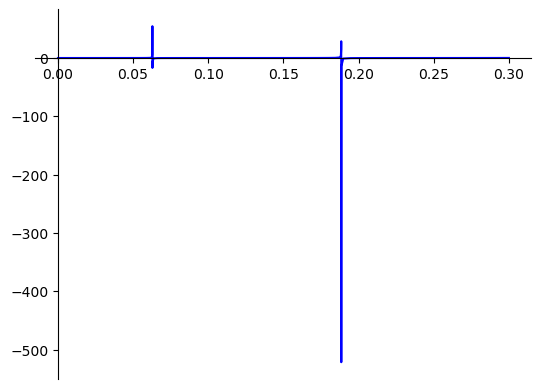

In [46]:
################################################################################
# Plot to investigate the roots
################################################################################
fun_1 = 1/ratio.lhs
fun_2 = 1/ratio.rhs

# Limits of the interval
start = 0
end = 0.3

# Create the plots
p1 = sp.plot(fun_1, (Bg_1_temp, start, end), label='lhs', show=False, line_color='blue', ylim=(-10, 10))
p2 = sp.plot(fun_2, (Bg_1_temp, start, end), label='rhs', show=False, line_color='orange', ylim=(-10, 10))

# Combine the plots
p1.extend(p2)

# Show the combined plot
p1.show()

In [47]:
################################################################################
# Core Buckling
################################################################################
sol_w = sp.nsolve(ratio, [0.0001])
print("First numerical Solution: ", sol_w)
# We noticed it always gave the second solution
core_width = Core_1.End - Core_1.Start
# Evaluate the value in the first period of the tangent
sol_w = (sol_w - sp.pi / core_width).evalf()
display(f"The buckling is {sol_w}")
# Convert to float
sol_w = float(sol_w)


ValueError: 
expected a one-dimensional and numerical function

In [ ]:
################################################################################
# Criticality Cond
################################################################################
# Finding the core region
for region in regions:
    if region.Composition == 'c':
        core = region

# Calculating the material buckling as a function of qual
material_buckling = (core.Nu * macro_fiss - macro_abs_core) / core.Diffusion

# Solving the criticality equation
criticality_cond = sp.Eq(material_buckling, sol_w, evaluate=False)
display(criticality_cond)
solve_crit = sp.solve(criticality_cond, qual)[0]
print("U235 fraction: ", solve_crit)

# Substituting the value of qual in the macroscopic cross sections
macro_fiss = macro_fiss.subs(qual, solve_crit)
macro_abs_core = macro_abs_core.subs(qual, solve_crit)

# Updating the macroscopic cross sections
Core_1.Absorption = macro_abs_core
Core_1.Fission = macro_fiss

Eq(446.034436710644*qual - 0.317742253537796, 0.0507026032650354)

U235 fraction:  0.000826045763461651


In [ ]:
################################################################################
# Substitute Bg and qual
################################################################################
for i, eq in enumerate(system):
    eq = eq.subs(qual, solve_crit)
    system[i] = eq.subs(Bg_1, sol_w)
    display(system[i])

Eq(phi_1(x), C_2*cos(0.0507026032650354*x))

Eq(phi_2(x - 25), 1318700.96634144*C_3*exp(-0.563686307743763*x))

Eq(0.298605584951051*C_2, C_3)

Eq(0.00774230054097452*C_2, 0.090189809239002*C_3)

Eq(1.64006908724855e-11*C_2, 625)

In [ ]:
# Get all the unkowns to compute
all_symbols = set()
for eq in system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)

unkowns = [flux.lhs for flux in fluxes]
for i in all_symbols:
    unkowns.append(i)

# Solve the system  
display(unkowns)
solution = sp.solve(system, unkowns)
display(solution)


[phi_1(x), phi_2(x - 25), C_3, C_2]

[]

In [ ]:
# Get the first two from the solution
phi1 = solution[fluxes[0].lhs]
display(Latex(f"$\phi_1 = {sp.latex(phi1)}$"))
phi2 = solution[fluxes[1].lhs]
display(Latex(f"$\phi_2 = {sp.latex(phi2)}$"))

x_sym = sp.symbols('x')
x_1 = np.linspace(Core_1.Start, Core_1.End, 100)
x_2 = np.linspace(Reflector_1.Start, 40, 100)
phi1_vals = [phi1.subs(x, val).evalf() for val in x_1]
phi2_vals = [phi2.subs(x, val).evalf() for val in x_2]

# Create symmetric values
x_1 = np.concatenate((-x_1[::-1], x_1))
phi1_vals = np.concatenate((phi1_vals[::-1], phi1_vals))
x_2_sx = -x_2[::-1]
phi2_vals_sx = phi2_vals[::-1]

# Plotting the fluxes
plt.plot(x_1, phi1_vals, label='Core Flux')
plt.plot(x_2, phi2_vals, label='Reflector Flux', color='orange')
plt.plot(x_2_sx, phi2_vals_sx, color='orange')
plt.xlabel('$x$')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not phi_1